In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time
from torch.optim.lr_scheduler import StepLR

In [2]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [3]:
def rand_tensor(min=0, max=1, size=(1)):
    out = (max - min) * torch.rand(size) + min
    return out

In [12]:
class Polynomial_func:
    def __init__(self, x, range=[-1,1], degree = 3, size=(1,1), sample_size=100, device="cuda"):
        self.x = x
        self.range = range
        self.degree = degree
        self.size = size
        self.sample_size = sample_size
        self.device = device

    def generate(self):
        hold = []
        for n in range(self.degree + 1):
            p = rand_tensor(
                min=self.range[0],
                max=self.range[1],
                size=(self.sample_size, self.size[0], self.size[1]),
            )
            hold.append(p)
        params = torch.stack(hold)
        params = torch.atleast_2d(params)
        params = torch.transpose(params, 0, 1)
        params = torch.transpose(params, 1, 2)
        params = params.to(self.device)

        x = (
            torch.cat(params.shape[0] * [self.x])
            .reshape(params.shape[0], -1)
            .to(self.device)
        )
        x = torch.transpose(x, 0, 1).to(self.device)
        y = torch.zeros_like(x)

        for d in range(self.degree+1):
            coeffs = params[:,0,d,0]
            y += coeffs*(x**d)
        out = torch.zeros(
                (params.shape[0], self.x.shape[0],
                self.size[0], self.size[1])
            ).to(self.device)            
        out[:,:,0,0] = torch.transpose(y,0,1)
        return torch.sum(out,dim=3)


In [37]:
class Sin_func:
    def __init__(self, x, range=[-1,1], size=(1, 1), sample_size=1000, device="cuda"):
        self.x = x
        self.range = range
        self.size = size
        self.sample_size = sample_size
        self.device = device

    def generate(self):
        amp = rand_tensor(
            min=self.range[0],
            max=self.range[1],
            size=(self.sample_size, self.size[0], self.size[1]),
        ).to(self.device)
        freq = rand_tensor(
            min=self.range[0],
            max=self.range[1],
            size=(self.sample_size, self.size[0], self.size[1]),
        ).to(self.device)
        phase = rand_tensor(
            min=self.range[0],
            max=self.range[1],
            size=(self.sample_size, self.size[0], self.size[1]),
        ).to(self.device)
        
        params = torch.stack((amp, freq, phase))
        params = torch.atleast_2d(params)
        params = torch.transpose(params, 0, 1)
        params = torch.transpose(params, 1, 2)
        params = params.to(self.device)

        x = (
            torch.cat(params.shape[0] * [self.x])
            .reshape(params.shape[0], -1)
            .to(self.device)
        )
        x = torch.transpose(x, 0, 1).to(self.device)
        y =  params[:,0,0,0] * torch.sin(2 * torch.pi * params[:,0,1,0] * x + params[:,0,2,0])
        out = torch.zeros(
                (params.shape[0], self.x.shape[0],
                self.size[0], self.size[1])
            ).to(self.device)  
        out[:, :, 0, 0] = torch.transpose(y, 0, 1)
        return torch.sum(out, dim=3)

In [38]:
def linear_function(params, x, device):
    x = x.to(device)
    if params.size(1) > 1:
        a = params[:, 0].type(torch.float).unsqueeze(1).to(device)
        b = params[:, 1].type(torch.float).unsqueeze(1).to(device)
        return a*x + b
    else:
        return torch.zeros_like(params)

def quadratic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    y = torch.zeros((params.size(0),x.shape[0])).to(device)
    if params.size(1) > 2:
        for n in range(len(params[0])):
            y += (params[:, n].type(torch.float).unsqueeze(1).to(device))*x**(3-n)
        return y
    else:
        return torch.zeros_like(params)

def cubic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    y = torch.zeros((params.size(0),x.shape[0])).to(device)
    if params.size(1) > 3:
        for n in range(len(params[0])):
            y += (params[:, n].type(torch.float).unsqueeze(1).to(device))*x**(3-n)
        return y
    else:
        return torch.zeros_like(params)
    
def sin_function(params, x, device):
    x = x.to(device)
    if params.size(1) == 3:
        amplitude = params[:, 0].type(torch.float).unsqueeze(1).to(device)
        frequency = params[:, 1].type(torch.float).unsqueeze(1).to(device)
        phase = params[:, 2].type(torch.float).unsqueeze(1).to(device)
        return amplitude * torch.sin(2 * torch.pi * frequency * x + phase)
    else:
        return torch.zeros_like(x)

In [630]:
def new_loss(output, target, x):
    #target_range = torch.max(target, dim=-1, keepdim=True)[0] - torch.min(target, dim=-1, keepdim=True)[0]
    #target_range = torch.clamp(target_range, min=1e-6).squeeze(-1)
    # print(target_range.shape)
    derivative_true = torch.autograd.grad(outputs=target.requires_grad_(True), inputs=x, grad_outputs=torch.ones_like(target), allow_unused=True)[0]
    if derivative_true is None:
        derivative_true = torch.zeros_like(output)
    derivative_pred = (torch.roll(output, shifts=-1, dims=0) - torch.roll(output, shifts=1, dims=0)) / (2 * 1e-8)
    mse_function = torch.mean(torch.abs(target - output)**3)#/target_range
    mse_derivative = torch.mean(torch.abs(derivative_pred - derivative_true)**3)#/target_range
    # print(mse_function + mse_derivative)
    return mse_function + mse_derivative

In [631]:
class Multi_Func(nn.Module):
    def __init__(self, functions, x_data, input_channels, device):
        super().__init__()
        self.device = device
        self.functions = functions  # [[function, (...)], [# params, (...)]]
        self.x_data = x_data
        self.input_channels = input_channels
        self.params = sum(self.functions[1])

        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.input_channels, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(64)
        )

        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.SELU(),
            nn.Linear(32, 20),
            nn.SELU(),
        )

        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(16),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(8),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(4),
        )

        self.flatten_layer = nn.Flatten()

        self.hidden_embedding = nn.Sequential(
            nn.Linear(28, 128), #28, 16
            nn.SELU(),
            nn.Linear(128, 64), #16, 8
            nn.SELU(),
            nn.Linear(64, self.params), #8
        )

    def forward(self, x, n=-1):
        target = x.squeeze(dim=2)
        x = torch.swapaxes(x, 1, 2).to(self.device)
        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (n, 256))
        xfc = self.hidden_xfc(xfc)

        x = torch.reshape(x, (n, 2, 128))
        x = self.hidden_x2(x)
        cnn_flat = self.flatten_layer(x)
        encoded = torch.cat((cnn_flat, xfc), 1)
        embedding = self.hidden_embedding(encoded)

        start_index = 0
        losses = []
        outputs = []
        
        for f in range(len(self.functions[0])):
            output = self.functions[0][f](
                embedding[:, start_index:start_index+self.functions[1][f]], 
                self.x_data, 
                device=self.device
            ).to(device)
            outputs.append(output)
            loss = new_loss(output, target, x)
            losses.append(loss)
            start_index += self.functions[1][f]
        
        #outputs = torch.stack(outputs)
        #losses = torch.stack(losses)
        best_index = torch.argmin(torch.tensor(losses))
        best_loss, best_out = losses[best_index], outputs[best_index]
        #best_loss, best_indexes = torch.min(losses, dim=0) 
        #best_out = outputs[best_indexes, -1]
        #best_func = [self.functions[0][idx] for idx in best_indexes]

        return best_out, best_loss, outputs, losses

In [145]:
sample_size = 1000
batch_size = 50
data_range = [-1, 1]
num_funcs = 4

x_values = torch.linspace(data_range[0], data_range[1], 1000)

linear = Polynomial_func(x=x_values, range=data_range, degree=1, sample_size=sample_size, device=device)
lin_full = linear.generate()

quad = Polynomial_func(x=x_values, range=data_range, degree=2, sample_size=sample_size, device=device)
quad_full = quad.generate()

cube = Polynomial_func(x=x_values, range=data_range, degree=3, sample_size=sample_size, device=device)
cube_full = cube.generate()

sin = Sin_func(x=x_values, range=data_range, sample_size=sample_size, device=device)
sin_full = sin.generate()

all_data = DataLoader(torch.vstack([cube_full, quad_full, lin_full, sin_full]), batch_size=batch_size, shuffle=True)

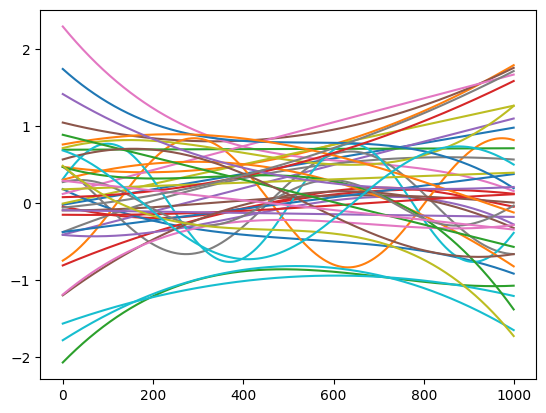

In [40]:
for i in range(10):
    r = np.random.randint(sample_size)
    plt.plot(lin_full[r, :, 0].detach().cpu().numpy(), "-")
    plt.plot(quad_full[r, :, 0].detach().cpu().numpy(), "-")
    plt.plot(cube_full[r, :, 0].detach().cpu().numpy(), "-")
    plt.plot(sin_full[r, :, 0].detach().cpu().numpy(), "-")

epoch : 0/10, loss = 0.18133942
--- 1.9965229034423828 seconds ---
epoch : 1/10, loss = 0.11272364
--- 1.9318981170654297 seconds ---
epoch : 2/10, loss = 0.08706074
--- 2.0337603092193604 seconds ---
epoch : 3/10, loss = 0.07571806
--- 1.9615943431854248 seconds ---
epoch : 4/10, loss = 0.12304313
--- 1.859257698059082 seconds ---
epoch : 5/10, loss = 0.12418085
--- 1.8692514896392822 seconds ---
epoch : 6/10, loss = 0.08285774
--- 1.8219306468963623 seconds ---
epoch : 7/10, loss = 0.10169927
--- 1.8880646228790283 seconds ---
epoch : 8/10, loss = 0.09231862
--- 1.9086368083953857 seconds ---
epoch : 9/10, loss = 0.11063417
--- 1.879162073135376 seconds ---


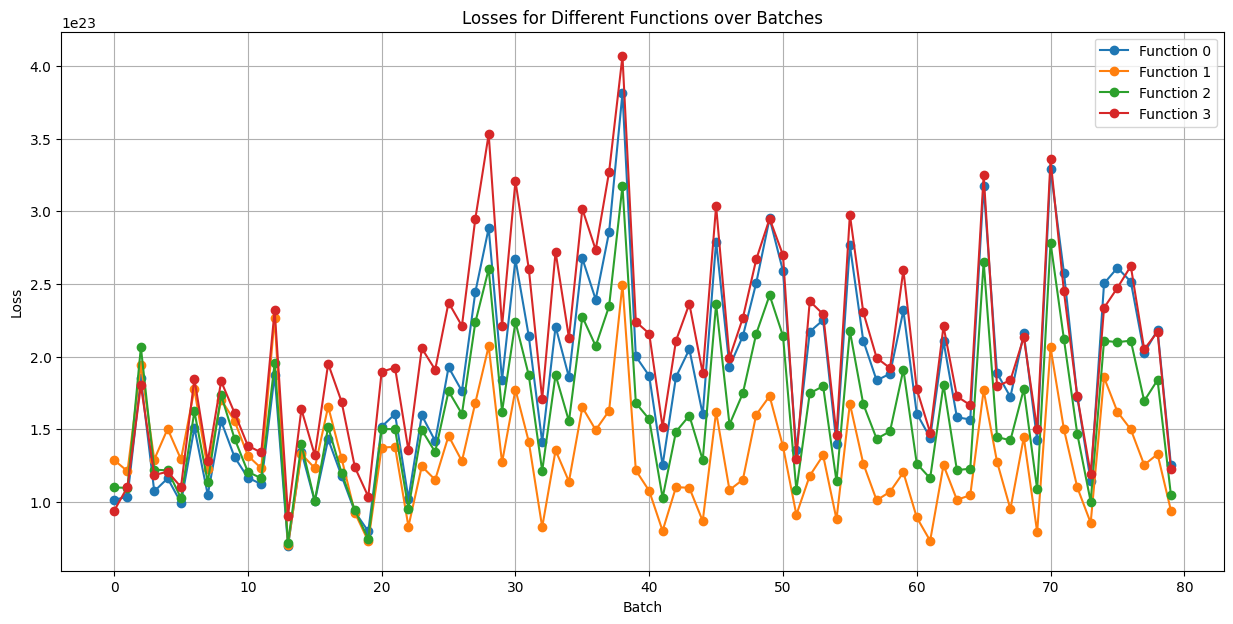

In [632]:
model = Multi_Func(functions=[[linear_function, quadratic_function, cubic_function, sin_function], [2,3,4,3]], x_data=x_values, input_channels=1, device=device).to(device)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

epochs = 10
for epoch in range(epochs):
    start_time = time.time()
    train_loss = 0.0
    total_num = 0
    model.train()
    function_losses = {i: [] for i in range(len(model.functions[0]))}
    
    for train_batch in all_data:
        train_batch = train_batch.to(device)
        target_batch = train_batch.squeeze(2).to(device)
        optimizer.zero_grad()
        best_out,best_loss,outputs,losses = model(train_batch)
        for i, loss in enumerate(losses):
            function_losses[i].append(loss.item())
        #print(best_out.shape)
        #print(target_batch.shape)
        loss = loss_func(best_out,target_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * best_out.shape[0]
        total_num += best_out.shape[0]
    scheduler.step()
    train_loss /= total_num
    print(f"epoch : {epoch}/{epochs}, loss = {train_loss:.8f}")
    print(f"--- {time.time() - start_time} seconds ---")

plt.figure(figsize=(15, 7))
for i in function_losses:
    plt.plot(range(len(function_losses[i])), function_losses[i], marker='o', label=f'Function {i}')

plt.title('Losses for Different Functions over Batches')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [523]:
t_sample_size = 100

t_x_values = torch.linspace(-1, 1, 1000)
t_linear = Polynomial_func(x=x_values, range=[-1,1], degree=1, sample_size=t_sample_size, device=device)
t_quad = Polynomial_func(x=x_values, range=[-1,1], degree=2, sample_size=t_sample_size, device=device)
t_cube = Polynomial_func(x=x_values, range=[-1,1], degree=3, sample_size=t_sample_size, device=device)
t_sin = Sin_func(x=t_x_values, range=data_range, sample_size=t_sample_size, device=device)


t_lin_full = t_linear.generate()
t_quad_full = t_quad.generate()
t_cube_full = t_cube.generate()
t_sin_full = t_sin.generate()


t_data = torch.vstack([t_lin_full, t_quad_full, t_cube_full, t_sin_full])

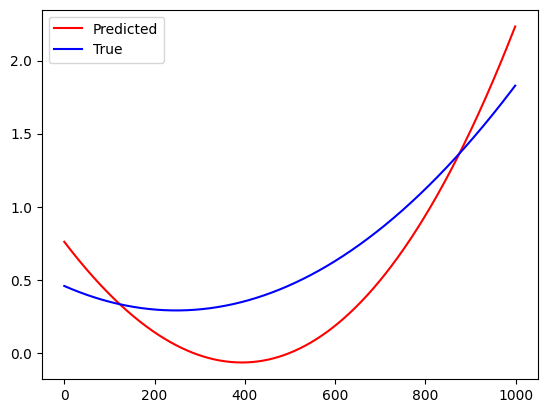

In [642]:
model.eval
best_out, best_loss, outputs, losses = model(t_data)
rand = np.random.randint(0, t_sample_size*num_funcs)
plt.plot(best_out[rand].detach().cpu().numpy(), "r", label='Predicted')
plt.plot(t_data[rand].detach().cpu().numpy(), "b", label='True')
plt.legend();

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


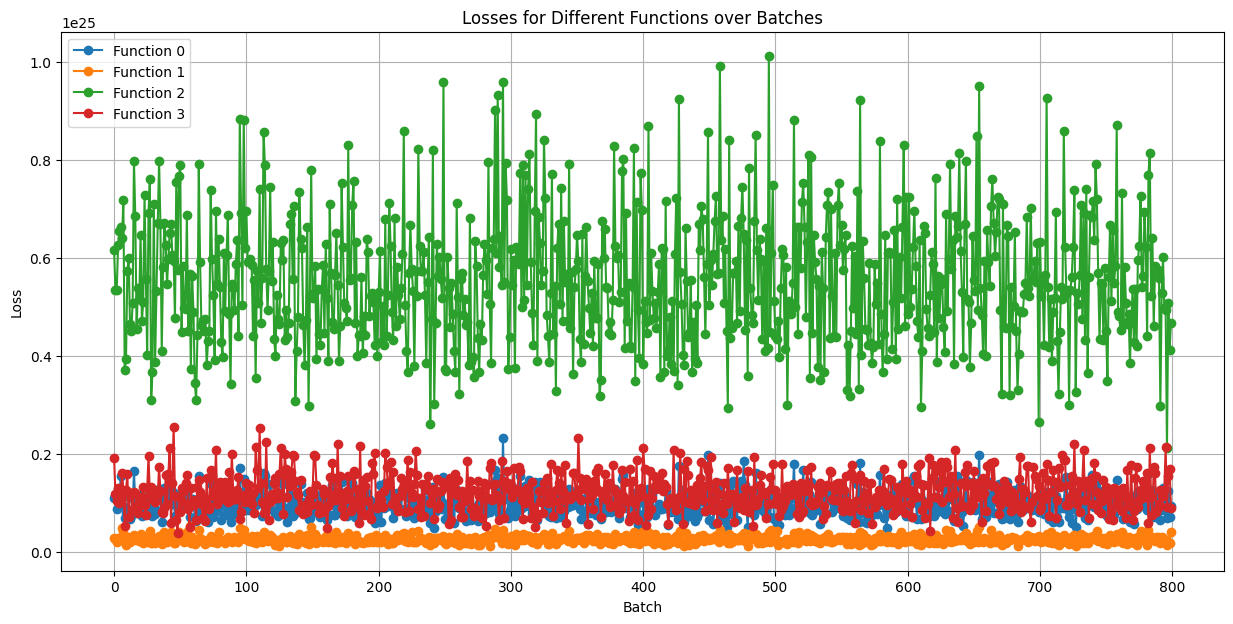

In [556]:
model2 = Multi_Func(functions=[[linear_function, quadratic_function, cubic_function, sin_function], [2,3,4,3]], x_data=x_values, input_channels=1, device=device).to(device)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)    
model2.train()
function_losses = {i: [] for i in range(len(model.functions[0]))}
    
for epoch in range(10):
    for batch in all_data:
        
        optimizer.zero_grad()
        _, _, outputs, losses = model2(batch)
        
        # Record losses for different functions
        for i, loss in enumerate(losses):
            function_losses[i].append(loss.item())
        
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{10}')
        
# Plot the losses for each function
plt.figure(figsize=(15, 7))
for i in function_losses:
    plt.plot(range(len(function_losses[i])), function_losses[i], marker='o', label=f'Function {i}')

plt.title('Losses for Different Functions over Batches')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
